Let's load and pre-process data

In [14]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:

nltk.download('punkt')
reddit = pd.read_json("../data/source/reddit_comments.json")
twitter = pd.read_csv("../data/source/twitter.csv")
YouTubeVideo = pd.read_excel("../data/source/ICWSM18 - SALMINEN ET AL.xlsx")
YouTube = YouTubeVideo[YouTubeVideo["type"].str.contains("post") == False]
fb = YouTubeVideo[YouTubeVideo["type"].str.contains("video") == False]
dfs = {"Reddit": reddit, "Twitter": twitter,"Youtube": YouTubeVideo, "Facebook": fb}

def overview(dfs):
    for name, df in dfs.items():
        print("\n")
        print(f"{name} description")
        print(df.info())
        print("\n")
        print(f"{name} example")
        print(df.head(5))

overview(dfs)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!




Reddit description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _replies                         18870 non-null  object 
 1   id                               18870 non-null  object 
 2   total_awards_received            18870 non-null  int64  
 3   approved_at_utc                  0 non-null      float64
 4   comment_type                     0 non-null      float64
 5   edited                           18870 non-null  int64  
 6   mod_reason_by                    0 non-null      float64
 7   banned_by                        0 non-null      float64
 8   author_flair_type                14966 non-null  object 
 9   removal_reason                   0 non-null      float64
 10  link_id                          18870 non-null  object 
 11  author_flair_template_id         857 non-null    object 
 1

In [3]:
def standardize_datasets(dfs):
    dfs["Twitter"] = dfs["Twitter"][["tweet", "class"]]
    dfs["Twitter"] = dfs["Twitter"].rename(columns={"tweet": "text", "class": "label"})
    # 0 indicates hate speech, 2 indicates nothing. we need to reencode to 0, 1. (0=no hate speech, 1=hate speech).
    dfs["Twitter"]["label"] = dfs["Twitter"]["label"].replace({0: 1, 2: 0})
    dfs["Reddit"] = dfs["Reddit"][["body", "is_hate"]]
    dfs["Reddit"] = dfs["Reddit"].rename(columns={"body": "text", "is_hate": "label"})
    dfs["Youtube"] = dfs["Youtube"][["message", "Class"]]
    dfs["Youtube"] = dfs["Youtube"].rename(columns={"message": "text", "Class": "label"})
    dfs["Youtube"]["label"] = dfs["Youtube"]["label"].replace({"Hateful": 1, "Neutral": 0})
    dfs["Facebook"] = dfs["Facebook"][["message", "Class"]]
    dfs["Facebook"] = dfs["Facebook"].rename(columns={"message": "text", "Class": "label"})
    dfs["Facebook"]["label"] = dfs["Facebook"]["label"].replace({"Hateful": 1, "Neutral": 0})

standardize_datasets(dfs)
overview(dfs)




Reddit description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18870 entries, 0 to 18869
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    18870 non-null  object 
 1   label   18860 non-null  float64
dtypes: float64(1), object(1)
memory usage: 295.0+ KB
None


Reddit example
                                                text  label
0  A subsection of retarded Hungarians? Ohh boy. ...    1.0
1  Hiii. Just got off work. 444 is mainly the typ...    0.0
2  wow i guess soyboys are the same in every country    0.0
3  Owen Benjamin's soyboy song goes for every cou...    0.0
4  wouldn't the defenders or whatever they are as...    1.0


Twitter description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24783 non-null  object
 1   label   24783 non-null  int64 
dtypes: int64

C:\Users\vital\AppData\Local\Temp\ipykernel_4724\403276306.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfs["Youtube"]["label"] = dfs["Youtube"]["label"].replace({"Hateful": 1, "Neutral": 0})
C:\Users\vital\AppData\Local\Temp\ipykernel_4724\403276306.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfs["Facebook"]["label"] = dfs["Facebook"]["label"].replace({"Hateful": 1, "Neutral": 0})


Let's check for missing values

In [4]:
def check_for_missing_values(dfs):
    for name, df in dfs.items():
        print(f"{name}")
        print(df.isnull().sum())

check_for_missing_values(dfs)

Reddit
text      0
label    10
dtype: int64
Twitter
text     0
label    0
dtype: int64
Youtube
text     1
label    0
dtype: int64
Facebook
text     1
label    0
dtype: int64


let's drop missings

In [5]:
def drop_missings(dfs):
    for name, df in dfs.items():
        df.dropna(inplace=True)

drop_missings(dfs)
check_for_missing_values(dfs)

Reddit
text     0
label    0
dtype: int64
Twitter
text     0
label    0
dtype: int64
Youtube
text     0
label    0
dtype: int64
Facebook
text     0
label    0
dtype: int64


Let's do some visualization

In [6]:
# Functions to calculate number of words and sentences
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

def count_sentences(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def process_df(df):
    # Apply functions to DataFrame
    df['num_words'] = df['text'].apply(count_words)
    df['num_sentences'] = df['text'].apply(count_sentences)

for name, df in dfs.items():
    process_df(df)

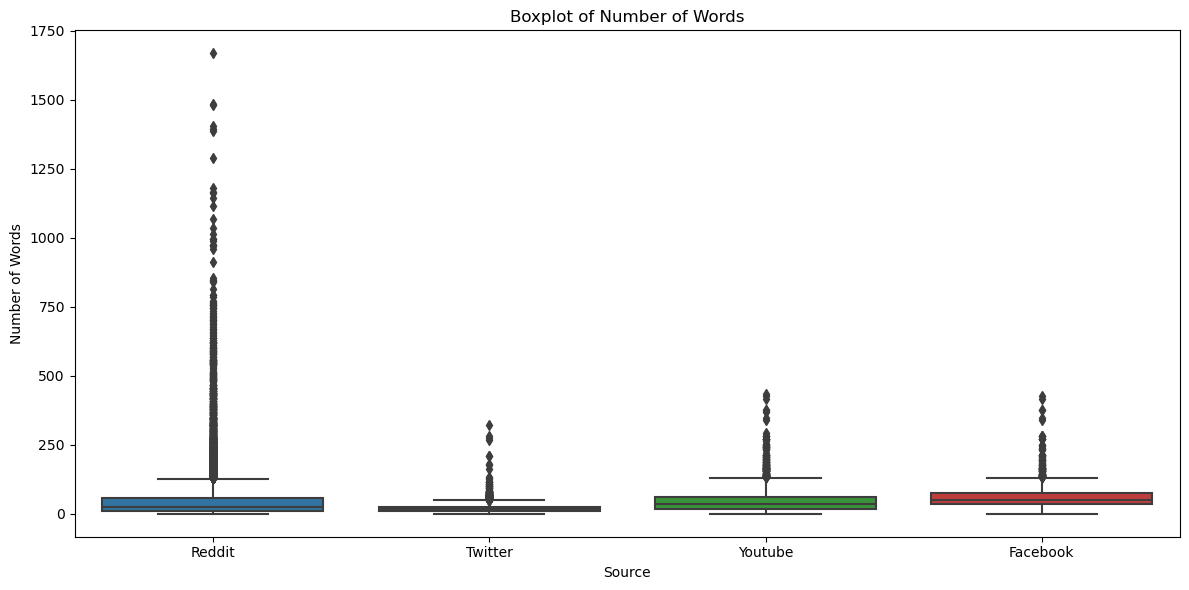

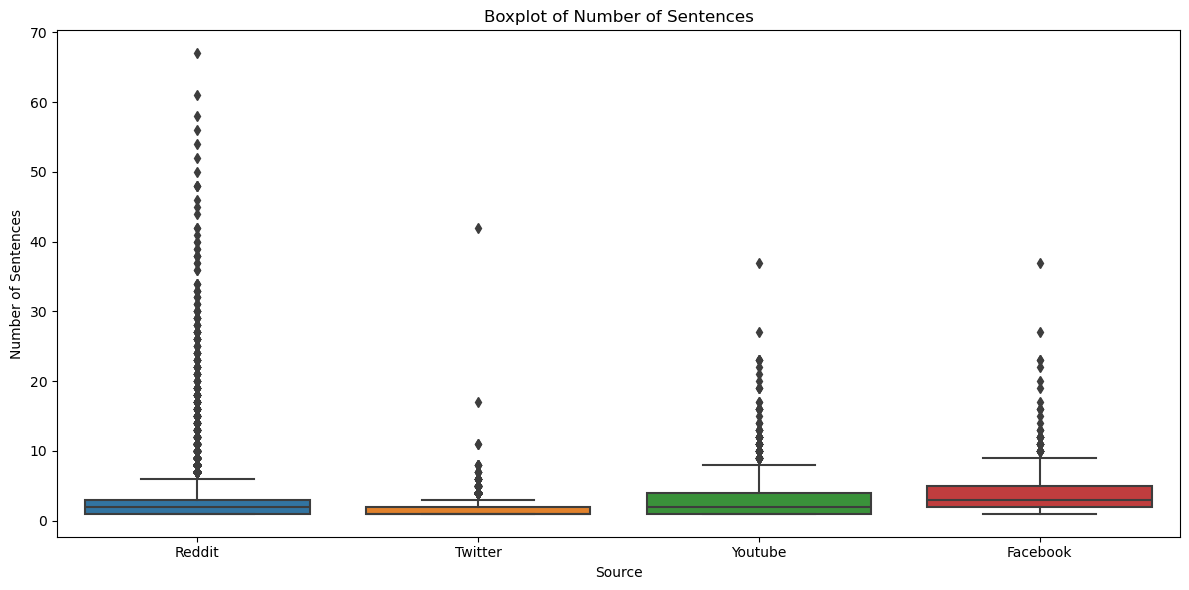

In [7]:
def plot_num_words(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df['source'] = name
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs)
plot_num_sentences(dfs)

Let's plot with an upper boundary on outliers, for better visibility

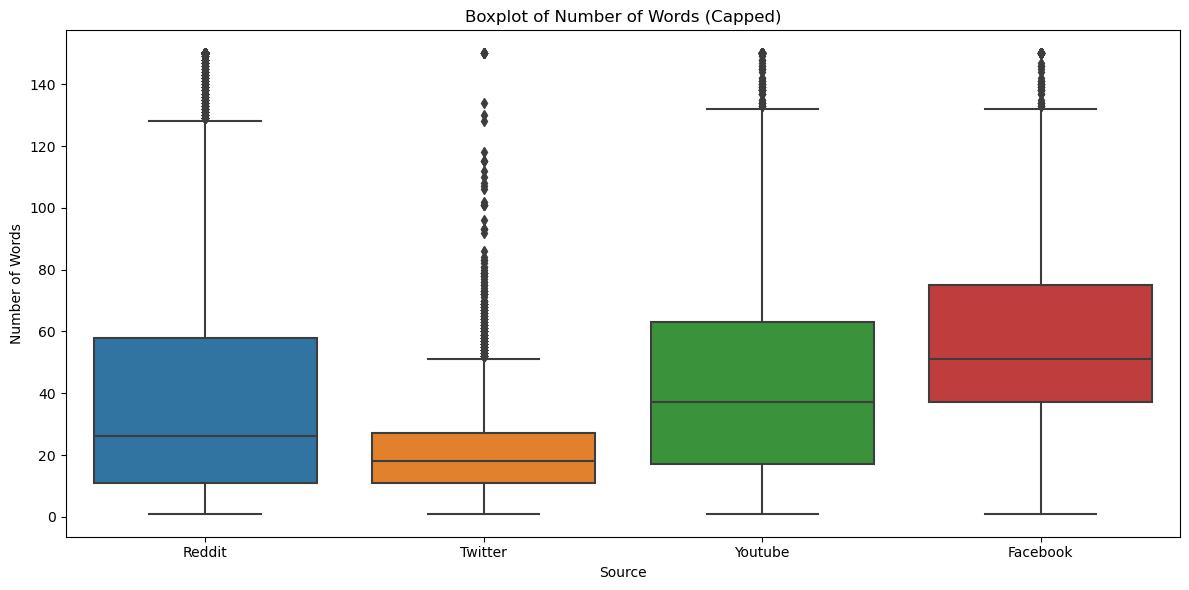

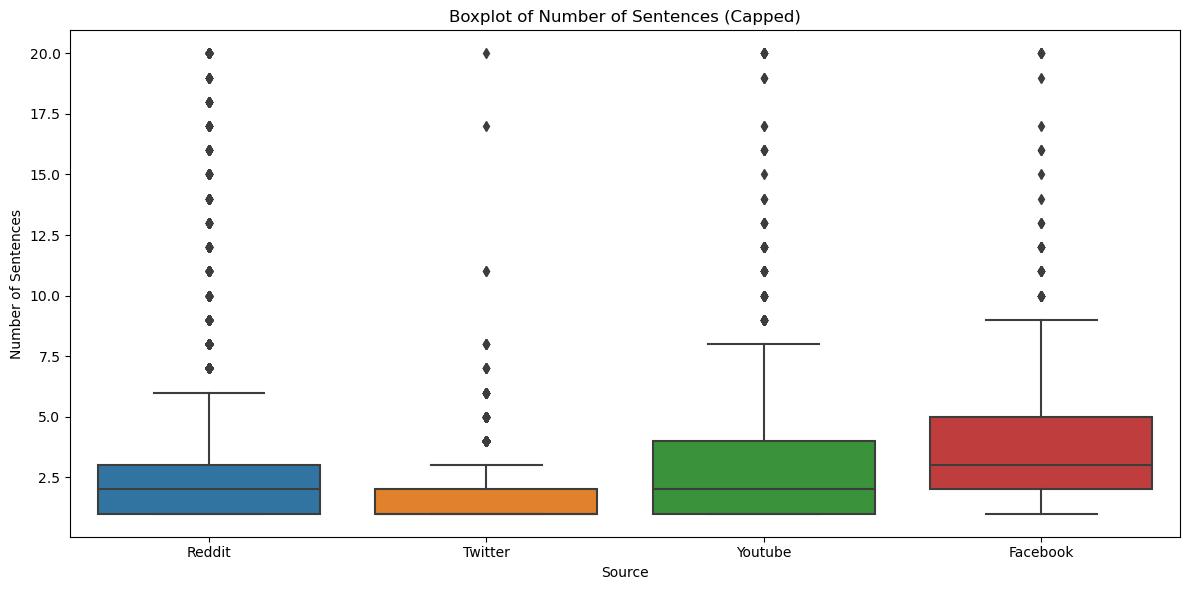

In [8]:
def cap_outliers(df, column, upper_bound):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].apply(lambda x: min(x, upper_bound))
    return df_copy

def plot_num_words(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_words', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_words', data=combined_df)
    plt.title('Boxplot of Number of Words (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Words')
    plt.tight_layout()
    plt.show()

def plot_num_sentences(dfs, upper_bound):
    # Combine all DataFrames into one for easier plotting
    combined_df = pd.DataFrame()
    for name, df in dfs.items():
        df_capped = cap_outliers(df, 'num_sentences', upper_bound)
        df_capped['source'] = name
        combined_df = pd.concat([combined_df, df_capped], ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='num_sentences', data=combined_df)
    plt.title('Boxplot of Number of Sentences (Capped)')
    plt.xlabel('Source')
    plt.ylabel('Number of Sentences')
    plt.tight_layout()
    plt.show()

plot_num_words(dfs, 150)
plot_num_sentences(dfs, 20)

Now let's examine labels

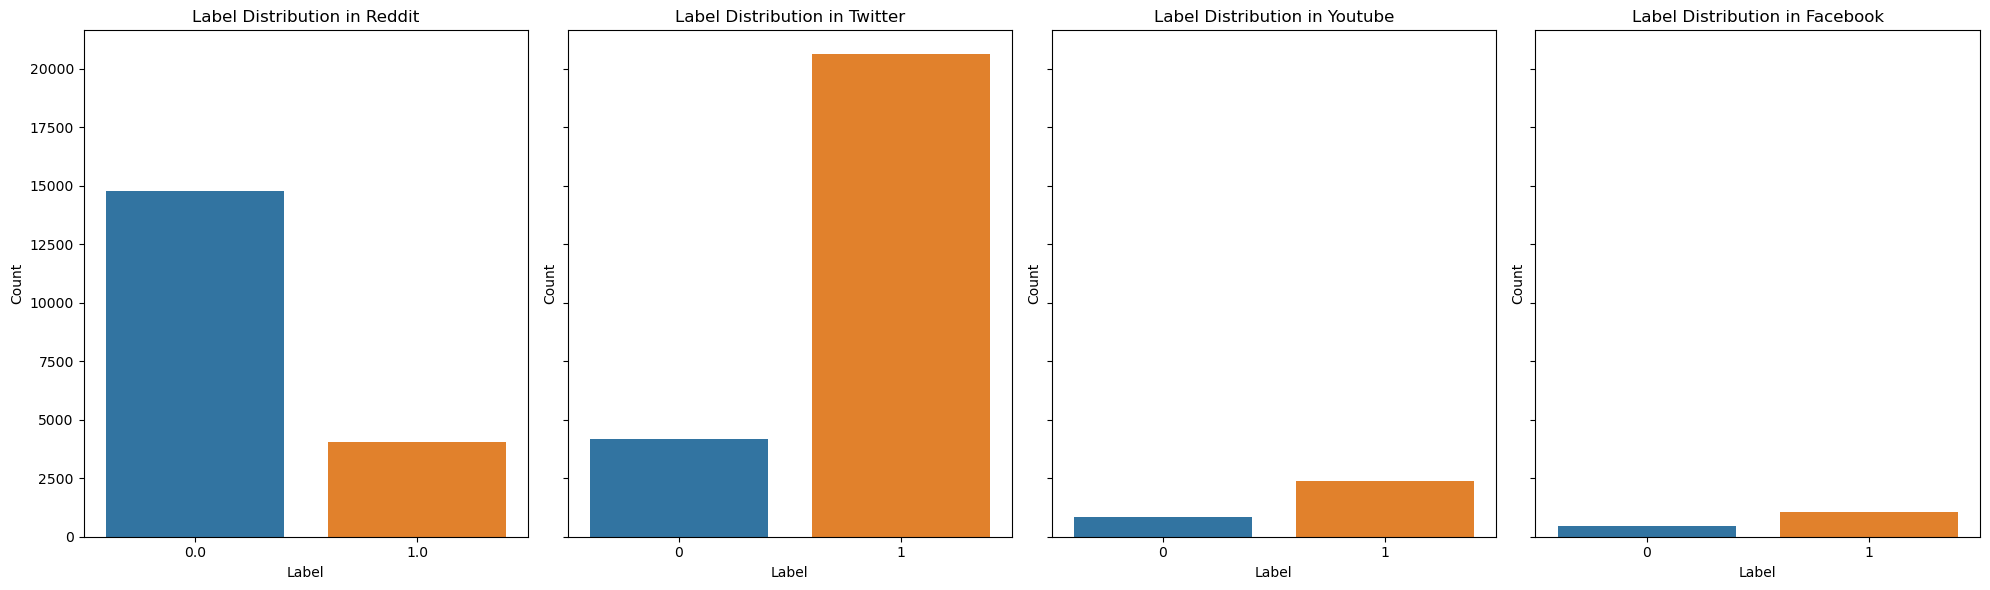

In [9]:
def plot_label_distribution(dfs):
    # Prepare the figure for subplots
    num_dfs = len(dfs)
    fig, axes = plt.subplots(1, num_dfs, figsize=(5 * num_dfs, 6), sharey=True)
    
    if num_dfs == 1:
        axes = [axes]  # Make sure axes is iterable if there's only one DataFrame

    # Plot each DataFrame
    for ax, (name, df) in zip(axes, dfs.items()):
        sns.countplot(x='label', data=df, ax=ax)
        ax.set_title(f'Label Distribution in {name}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_label_distribution(dfs)

In [15]:
for key, df in dfs.items():
    df1 = df.copy()
    df1.drop(columns=["num_words", "source", "num_sentences"], inplace=True)
    df1_train, df1_test = train_test_split(df1, test_size=0.2, random_state=42, stratify=df1['label'])
    df1_train.to_csv(os.path.join("..\\data\\intermediary\\train", f"cleaned_{key.lower()}_train.csv"), index=False)
    df1_test.to_csv(os.path.join("..\\data\\intermediary\\test", f"cleaned_{key.lower()}_test.csv"), index=False)


In [71]:
import re


def clean_text(text):
    """
    Clean the input text by removing retweets, Unicode emojis, usernames, URLs, and specific special characters
    while allowing exclamation marks, question marks, and commas.
    Parameters:
        text (str): The text to be cleaned.
    Returns:
        str: The cleaned text.
    """
    # Remove RT and anything that follows up to the colon (common in retweets)
    text = re.sub(r'RT @\w+:', '', text)

    # Remove all 'RT' (common in retweets) that are all caps and not followed by a letter
    text = re.sub(r'\bRT\b(?![a-zA-Z])', '', text)

    # Remove Unicode characters (emojis)
    text = re.sub(r'\\u[0-9A-Fa-f]{4}', '', text)

    # Remove Twitter handles
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove special characters and punctuation except !, ?, and ,
    # This regex keeps ',', '!', '?', and removes other special characters
    text = re.sub(r'[!"#$%&\'()*+-./:;<=>@[\\\]^_`{|}~]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
#remove nulls
def remove_nulls(df):
    """
    Remove rows with null values from a DataFrame.

    Args:
    df (pandas.DataFrame): The DataFrame from which to remove null values.

    Returns:
    pandas.DataFrame: The DataFrame with null values removed.
    """
    return df.dropna()


# def remove_urls(text):
#     """
#     Remove URLs from a given text string.
#
#     Args:
#     text (str): The text from which URLs need to be removed.
#
#     Returns:
#     str: The text with URLs removed.
#     """
#     # Regex pattern to match URLs
#     url_pattern = r'https?://\S+|www\.\S+'
#     # Replace URLs with an empty string
#     cleaned_text = re.sub(url_pattern, '', text)
#     return cleaned_text

def remove_outliers_by_word_length(text, std_dev_threshold=3):
    """
    Remove words from the text that are outliers in terms of their length.

    Args:
    text (str): The input text from which to remove word length outliers.
    std_dev_threshold (int): The number of standard deviations to use as the cutoff. Defaults to 3.

    Returns:
    str: The text with outliers removed.
    """
    words = text.split()
    word_lengths = [len(word) for word in words]

    # Calculate the mean and standard deviation of word lengths
    mean_length = np.mean(word_lengths)
    std_dev_length = np.std(word_lengths)

    # Define word length boundaries
    lower_bound = mean_length - std_dev_threshold * std_dev_length
    upper_bound = mean_length + std_dev_threshold * std_dev_length

    # Filter words that are within the boundary
    filtered_words = [word for word, length in zip(words, word_lengths) if lower_bound <= length <= upper_bound]

    # Join words back into a single string
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text


def remove_message_length_outliers(df, column_name, sigma_threshold=3):
    """
    Remove messages that are outliers based on the total number of words in each message directly within a DataFrame.

    Args:
    df (pandas.DataFrame): DataFrame containing the messages.
    column_name (str): Column name of text messages.
    sigma_threshold (int): The number of standard deviations to use as the cutoff. Defaults to 3.

    Returns:
    pandas.DataFrame: DataFrame with outliers removed.
    """
    # Calculate word counts for each message
    word_counts = df[column_name].apply(lambda x: len(x.split()))

    # Calculate the mean and standard deviation of word counts
    mean_count = np.mean(word_counts)
    std_dev_count = np.std(word_counts)

    # Define message length boundaries
    lower_bound = mean_count - sigma_threshold * std_dev_count
    upper_bound = mean_count + sigma_threshold * std_dev_count

    # Create a mask of messages that are within the boundary
    mask = (word_counts >= lower_bound) & (word_counts <= upper_bound)

    # Return filtered DataFrame
    return df[mask]


# def apply_cleaning_to_dataframe(df, column_name):
#     """
#     Apply the cleaning function to a specific column in a DataFrame.
#     Parameters:
#         df (pandas.DataFrame): The DataFrame containing the text to be cleaned.
#         column_name (str): The name of the column to clean.
#     Returns:
#         pandas.DataFrame: The DataFrame with the text in the specified column cleaned.
#     """
#     df[column_name] = df[column_name].apply(clean_text)
#
#     return df

In [72]:
# sanity check
sample_tweet = "RT This is an example tweet! Check out https://example.com"
cleaned_tweet = clean_text(sample_tweet)
print(cleaned_tweet)

This is an example tweet Check out


In [73]:


input_csv_twitter = '../data/intermediary/cleaned_twitter.csv'
input_csv_yt = '../data/intermediary/cleaned_youtube.csv'
input_csv_fb = '../data/intermediary/cleaned_facebook.csv'
input_csv_reddit = '../data/intermediary/cleaned_reddit_int.csv'

list_of_csvs = [input_csv_twitter, input_csv_yt, input_csv_fb, input_csv_reddit]


# Load the data
df_twitter = pd.read_csv(input_csv_twitter)
df_yt = pd.read_csv(input_csv_yt)
df_fb = pd.read_csv(input_csv_fb)
df_reddit = pd.read_csv(input_csv_reddit)

# list of dataframes
dfs = [df_twitter, df_yt, df_fb, df_reddit]

# apply cleaning to twitter
df_twitter['text'] = df_twitter['text'].apply(clean_text)

# remove urls from all dfs already done by clean
# for df in dfs:
#     df['text'] = df['text'].apply(remove_urls)

# remove outliers by word length from all dfs
for df in dfs:
#apply the function to remove outliers based on word length
    df['text'] = df['text'].apply(remove_outliers_by_word_length)

#remove nulls from all dfs
for df in dfs:
    df = remove_nulls(df)


# remove outliers by message length from all dfs

for df in dfs:
    df = remove_message_length_outliers(df, 'text', sigma_threshold=3)


In [ ]:
# # Create a sample DataFrame with some text
# data = {
#     'text': [
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "short",
#         "medium text slightly longer",
#         "longer text that should be closer to average but not too long",
#         "extremely long text string that is definitely an outlier and should be removed by the function based on its excessive length",
#         "short"
#     ]
# }
#
# test_df = pd.DataFrame(data)
#
# # Apply the function to remove outliers based on message length
# test_df_clean = remove_message_length_outliers(test_df, 'text', sigma_threshold=2)  # Using a 2-sigma threshold for a clearer effect
# print(test_df_clean)

In [74]:
#print longest message in each dataframe
for df in [df_twitter, df_yt, df_fb, df_reddit]:
    print(df['text'].apply(len).max())

503
2154
2073
8111


In [75]:
#print heads of all dataframes
for df in [df_twitter, df_yt, df_fb, df_reddit]:
    print(df.head())

                                                text  label
0  As a woman you shouldnt complain about cleanin...      0
1  boy dats coldtyga dwn bad for cuffin dat hoe i...      1
2  Dawg You ever fuck a bitch and she start to cr...      1
3                             she look like a tranny      1
4  The shit you hear about me might be true or it...      1
                                                text  label
0  this is disgusting and they should do the same...      1
1  Fuck that cop. Nothing but a fucking thug. Gan...      1
2  Fucking piece of shit cops, protect and serve ...      1
3  Land of the free... My fucking ass. America is...      1
4             These fucking cops are out of control!      1
                                                text  label
0  People should just group up and jump these fuc...      1
1  Of course cops couldn't make it before the rob...      1
2  AJ+ is an incredibly dishonest and biased page...      1
3  All BS! Here in rio having a ball! Th

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def undersample(df, label_column):
    class_counts = df[label_column].value_counts()
    min_class_count = class_counts.min()
    df_balanced = pd.concat([
        df[df[label_column] == label].sample(min_class_count, random_state=42, replace=False).reset_index(drop=True)
        for label in class_counts.index
    ])
    return df_balanced

def oversample(df, label_column):
    class_counts = df[label_column].value_counts()
    max_class_count = class_counts.max()
    df_balanced = pd.concat([
        resample(df[df[label_column] == label],
                 replace=True,
                 n_samples=max_class_count,
                 random_state=42).reset_index(drop=True)
        for label in class_counts.index
    ])
    return df_balanced



In [76]:
# Apply undersampling to reddit and twitter
# train test split for reddit and twitter
# train test split import
from sklearn.model_selection import train_test_split

df_twitter_train, df_twitter_test = train_test_split(df_twitter, test_size=0.2, random_state=42, stratify=df_twitter['label'])
df_reddit_train, df_reddit_test = train_test_split(df_reddit, test_size=0.2, random_state=42, stratify=df_reddit['label'])

# undersample twitter and reddit
df_twitter_balanced = undersample(df_twitter_train, 'label')
df_reddit_balanced = undersample(df_reddit_train, 'label')


In [77]:
#print heads of all dataframes
for df in [df_twitter_balanced, df_reddit_balanced, df_fb, df_yt]:
    print(df.head())

                                                text  label
0                      Waka Flaka a lucky retard lol      1
1  Just unfollowed another crazy bitch Whos next?...      1
2                    Marijuana turn good pussy great      1
3  yall boyz was fried Fuck dat pussy nigga in th...      1
4  I ont care cuz I got hoes Dats rite I got plen...      1
                                                text  label
0  Any 14 year old that doesn't know something ab...      0
1  Welp, I must have missed that news. I still wa...      0
2  It's almost like these people use words withou...      0
3  Interesting. I think there’s a whole AI person...      0
4  Point to where I said obvious? Not once in my ...      0
                                                text  label
0  People should just group up and jump these fuc...      1
1  Of course cops couldn't make it before the rob...      1
2  AJ+ is an incredibly dishonest and biased page...      1
3  All BS! Here in rio having a ball! Th

In [78]:
# oversample facebook and youtube

#train test split for facebook and youtube
df_fb_train, df_fb_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

df_yt_train, df_yt_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# oversample facebook and youtube
df_fb_balanced = oversample(df_fb_train, 'label')
df_yt_balanced = oversample(df_yt_train, 'label')


In [86]:


#print for each dataframe the test and train sizes and full size

print("Train and test sizes:")
for df_train, df_test in [(df_twitter_train, df_twitter_test), (df_reddit_train, df_reddit_test), (df_fb_train, df_fb_test), (df_yt_train, df_yt_test)]:
    print(f"Train size: {df_train.shape[0]}, Test size: {df_test.shape[0]}")
    print(f"Full size: {df_train.shape[0] + df_test.shape[0]}")


Train and test sizes:
Train size: 19826, Test size: 4957
Full size: 24783
Train size: 15088, Test size: 3772
Full size: 18860
Train size: 2576, Test size: 645
Full size: 3221
Train size: 2576, Test size: 645
Full size: 3221


In [80]:
#print heads of all dataframes
for df in [df_twitter_balanced, df_reddit_balanced, df_fb_balanced, df_yt_balanced]:
    print(df.head())


                                                text  label
0                      Waka Flaka a lucky retard lol      1
1  Just unfollowed another crazy bitch Whos next?...      1
2                    Marijuana turn good pussy great      1
3  yall boyz was fried Fuck dat pussy nigga in th...      1
4  I ont care cuz I got hoes Dats rite I got plen...      1
                                                text  label
0  Any 14 year old that doesn't know something ab...      0
1  Welp, I must have missed that news. I still wa...      0
2  It's almost like these people use words withou...      0
3  Interesting. I think there’s a whole AI person...      0
4  Point to where I said obvious? Not once in my ...      0
                                                text  label
0  Did the shooter do it for religious, political...      1
1  FUCK THEM .. THEY WILL RUIN YOUR COUNTRY IF U ...      1
2  :( I'm just getting angry afrer seeing this on...      1
3  Pray for Dallas :))) 281 died in Iraq

In [92]:
# # # save data to csv before any oversampling or undersampling, named further_cleaned_{name}.csv
# df_twitter.to_csv('../data/usable/further_cleaned_twitter.csv', index=False)
# df_reddit.to_csv('../data/usable/further_cleaned_reddit.csv', index=False)
# df_fb.to_csv('../data/usable/further_cleaned_facebook.csv', index=False)
# df_yt.to_csv('../data/usable/further_cleaned_youtube.csv', index=False)
# #
# # # save data to csv after oversampling or undersampling, named balanced_{name}.csv in the /data/usable folder
# df_twitter_balanced.to_csv('../data/usable/balanced_twitter.csv', index=False)
# df_reddit_balanced.to_csv('../data/usable/balanced_reddit.csv', index=False)
# df_fb_balanced.to_csv('../data/usable/balanced_facebook.csv', index=False)
# df_yt_balanced.to_csv('../data/usable/balanced_youtube.csv', index=False)

#for train and test dataframes, save them to csv files in the /data/usable folder both for balanced and further cleaned data, there should be 16 csvs in total,
for df, name in [(df_twitter_train, 'twitter_train'), (df_twitter_test, 'twitter_test'),
                 (df_reddit_train, 'reddit_train'), (df_reddit_test, 'reddit_test'),
                 (df_fb_train, 'facebook_train'), (df_fb_test, 'facebook_test'),
                 (df_yt_train, 'youtube_train'), (df_yt_test, 'youtube_test'),
                 (df_twitter_balanced, 'balanced_twitter_train'), (df_reddit_balanced, 'balanced_reddit_train'),
                 (df_fb_balanced, 'balanced_facebook_train'), (df_yt_balanced, 'balanced_youtube_train')]:
    df.to_csv(f'../data/usable/{name}.csv', index=False)

# for the 4 test balanced dataframes, save them to csv files in the /data/usable folder
for df, name in [(df_twitter_test, 'balanced_twitter_test'), (df_reddit_test, 'balanced_reddit_test'),
                 (df_fb_test, 'balanced_facebook_test'), (df_yt_test, 'balanced_youtube_test')]:
    df.to_csv(f'../data/usable/{name}.csv', index=False)


#sanity check
# heads of all dataframes
for df in [df_twitter_train, df_twitter_test, df_reddit_train, df_reddit_test, df_fb_train, df_fb_test, df_yt_train, df_yt_test, df_twitter_balanced, df_reddit_balanced, df_fb_balanced, df_yt_balanced]:
    print(df.head())
    # size
    print("size ", df.shape[0])

                                                    text  label
8502                                       Come back hoe      1
17783          Bouta take a shower just to fuck yo bitch      1
21158                       Stiff armed his hoe ass lmao      1
3599   ugly goldigging cunt u probably have an uncirc...      1
9245                   Fuck bitches get money ayyyyeeeee      1
size  19826
                                                    text  label
23768  dont even entertain these hoes got somebody to...      1
22820  Who the hell taught you how to fuck bitch toot...      1
18564  8220 Or Run wildcat Let Romo run that deep pos...      1
21255  Switcheroo on yo main hoe hell naw me and my N...      1
11185  Ill walk away with your money and leave a tip ...      1
size  4957
                                                    text  label
7723                      No I believe men. \#sheliedtoo      0
12598  The commitments told me they were the blacks o...      0
12981  wow... i m